In [26]:
# train_classification_model.py

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# Load environment variables and connect to DB
load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")
engine = create_engine(DATABASE_URL)

# Load final dataset
df = pd.read_sql("SELECT * FROM final_features", engine, parse_dates=["date"])
df = df.sort_values(["ticker", "date"])

# Drop rows with missing label
df = df.dropna(subset=["trade_signal"])

In [32]:
df

,ticker,date,close,volume,return_1d,sma_5,sma_20,ema_10,rsi_14,macd,...,roe,capexPerShare,fetched_at_x,interest_rate,cpi,unemployment,fetched_at_y,merged_at,target_return_5d,trade_signal
0,NVDA,1999-01-22,0.041016,2714688000,NaN,NaN,NaN,0.041016,NaN,0.000000,...,NaN,NaN,NaT,4.63,164.300,4.3,2025-06-19 05:48:23.043012,2025-06-19 11:27:19.350780+00:00,-0.034938,SELL
1,NVDA,1999-01-25,0.045313,510480000,0.104764,NaN,NaN,0.041797,NaN,0.000343,...,NaN,NaN,NaT,4.63,164.300,4.3,2025-06-19 05:48:23.043012,2025-06-19 11:27:19.350780+00:00,-0.109196,SELL
2,NVDA,1999-01-26,0.041797,343200000,-0.077594,NaN,NaN,0.041797,NaN,0.000327,...,NaN,NaN,NaT,4.63,164.300,4.3,2025-06-19 05:48:23.043012,2025-06-19 11:27:19.350780+00:00,-0.109027,SELL
3,NVDA,1999-01-27,0.041667,244368000,-0.003110,NaN,NaN,0.041774,NaN,0.000300,...,NaN,NaN,NaT,4.63,164.300,4.3,2025-06-19 05:48:23.043012,2025-06-19 11:27:19.350780+00:00,-0.087503,SELL
4,NVDA,1999-01-28,0.041536,227520000,-0.003144,0.042266,NaN,0.041730,NaN,0.000266,...,NaN,NaN,NaT,4.63,164.300,4.3,2025-06-19 05:48:23.043012,2025-06-19 11:27:19.350780+00:00,-0.034476,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6633,NVDA,2025-06-05,139.990005,231397900,-0.013599,139.128003,133.176501,137.267302,58.853811,6.326936,...,0.918729,0.131786,2025-06-19 05:48:15.928054,4.33,321.465,4.2,2025-06-19 05:48:23.043012,2025-06-19 11:27:19.350780+00:00,0.035788,BUY
6634,NVDA,2025-06-06,141.720001,153986200,0.012358,140.446002,134.394001,138.076883,60.429049,6.289989,...,0.918729,0.131786,2025-06-19 05:48:15.928054,4.33,321.465,4.2,2025-06-19 05:48:23.043012,2025-06-19 11:27:19.350780+00:00,0.001764,HOLD
6635,NVDA,2025-06-09,142.630005,185114500,0.006421,141.496002,135.693001,138.904724,61.372416,6.261954,...,0.918729,0.131786,2025-06-19 05:48:15.928054,4.33,321.465,4.2,2025-06-19 05:48:23.043012,2025-06-19 11:27:19.350780+00:00,0.014443,HOLD
6636,NVDA,2025-06-10,143.960007,155881900,0.009325,142.044003,136.741001,139.823866,65.362411,6.274724,...,0.918729,0.131786,2025-06-19 05:48:15.928054,4.33,321.465,4.2,2025-06-19 05:48:23.043012,2025-06-19 11:27:19.350780+00:00,0.001111,HOLD


In [30]:

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(df["trade_signal"])

In [31]:
y

array([2, 2, 2, ..., 1, 1, 0], shape=(6638,))


📘 Fold 1


/Users/jayeshkadam/Library/Mobile Documents/com~apple~CloudDocs/Projects/Quantitative Stock Forecasting System/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [06:16:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


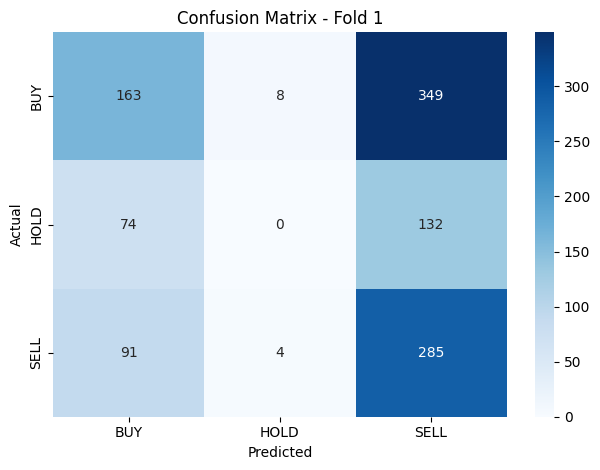

              precision    recall  f1-score   support

         BUY       0.50      0.31      0.38       520
        HOLD       0.00      0.00      0.00       206
        SELL       0.37      0.75      0.50       380

    accuracy                           0.41      1106
   macro avg       0.29      0.35      0.29      1106
weighted avg       0.36      0.41      0.35      1106


📘 Fold 2


/Users/jayeshkadam/Library/Mobile Documents/com~apple~CloudDocs/Projects/Quantitative Stock Forecasting System/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [06:16:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


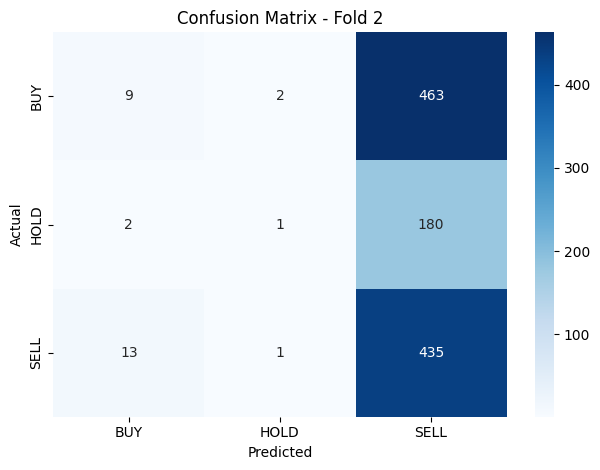

              precision    recall  f1-score   support

         BUY       0.38      0.02      0.04       474
        HOLD       0.25      0.01      0.01       183
        SELL       0.40      0.97      0.57       449

    accuracy                           0.40      1106
   macro avg       0.34      0.33      0.21      1106
weighted avg       0.37      0.40      0.25      1106


📘 Fold 3


/Users/jayeshkadam/Library/Mobile Documents/com~apple~CloudDocs/Projects/Quantitative Stock Forecasting System/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [06:16:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


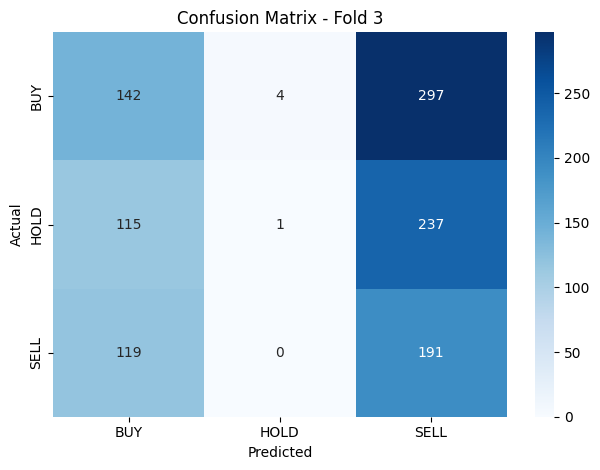

              precision    recall  f1-score   support

         BUY       0.38      0.32      0.35       443
        HOLD       0.20      0.00      0.01       353
        SELL       0.26      0.62      0.37       310

    accuracy                           0.30      1106
   macro avg       0.28      0.31      0.24      1106
weighted avg       0.29      0.30      0.24      1106


📘 Fold 4


/Users/jayeshkadam/Library/Mobile Documents/com~apple~CloudDocs/Projects/Quantitative Stock Forecasting System/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [06:16:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


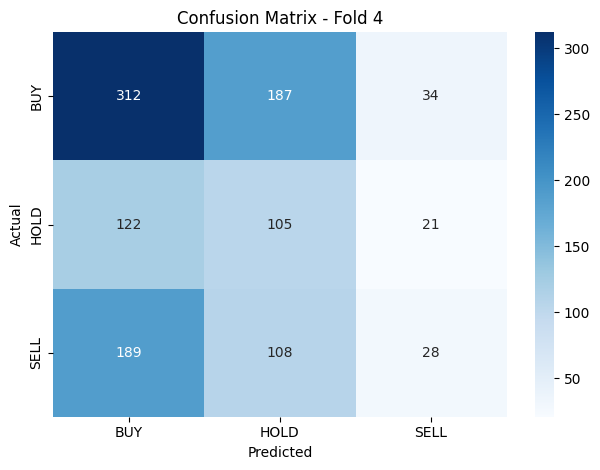

              precision    recall  f1-score   support

         BUY       0.50      0.59      0.54       533
        HOLD       0.26      0.42      0.32       248
        SELL       0.34      0.09      0.14       325

    accuracy                           0.40      1106
   macro avg       0.37      0.36      0.33      1106
weighted avg       0.40      0.40      0.37      1106


📘 Fold 5


/Users/jayeshkadam/Library/Mobile Documents/com~apple~CloudDocs/Projects/Quantitative Stock Forecasting System/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [06:16:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


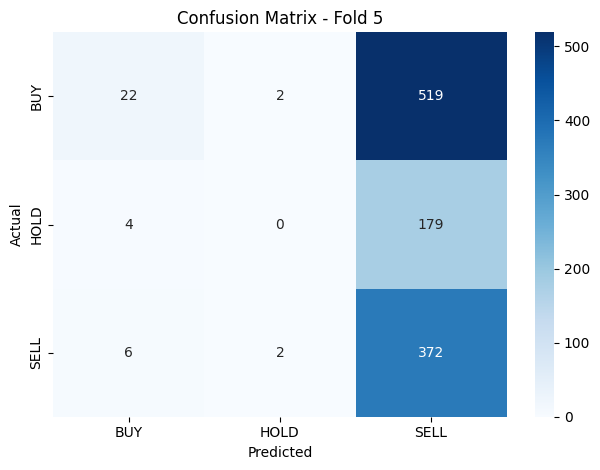

              precision    recall  f1-score   support

         BUY       0.69      0.04      0.08       543
        HOLD       0.00      0.00      0.00       183
        SELL       0.35      0.98      0.51       380

    accuracy                           0.36      1106
   macro avg       0.35      0.34      0.20      1106
weighted avg       0.46      0.36      0.21      1106



In [34]:

# Select numeric features only
exclude_cols = ["date", "ticker", "target_return_5d", "trade_signal", "merged_at"]
X = df.drop(columns=[col for col in exclude_cols if col in df.columns])
X = X.select_dtypes(include=np.number).fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
all_reports = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
    print(f"\n📘 Fold {fold+1}")
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, use_label_encoder=False, eval_metric="mlogloss")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    all_reports.append(report)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    print(classification_report(y_test, y_pred, target_names=le.classes_))
